In [28]:
import uproot, ROOT, glob, os, random
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
from sklearn.metrics import roc_curve, roc_auc_score, auc
from tqdm import tqdm
import pandas as pd
from xgboost import XGBClassifier
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split

# Set up plot defaults
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 12.0,8.0  # Roughly 11 cm wde by 8 cm high
mpl.rcParams['font.size'] = 16.0 # Use 14 point font
sns.set(style="whitegrid")

path = '/eos/user/j/jlai/ditau/'

In [30]:
branches = ['ditau_pt', 'n_subjets', 'IsTruthHadronic', 'n_tracks_lead', 'n_tracks_subl',
 'R_max_lead', 'R_max_subl', 'R_tracks_subl', 'R_isotrack', 'd0_leadtrack_lead',
 'd0_leadtrack_subl', 'f_core_lead', 'f_core_subl', 'f_subjet_subl', 'f_subjets',
 'f_isotracks', 'm_core_lead', 'm_core_subl', 'm_tracks_lead', 'm_tracks_subl',
 'n_track']

training_vars = [
    "f_core_lead", "f_core_subl", "f_subjet_subl", "f_subjets", "f_isotracks",
    "R_max_lead", "R_max_subl", "R_isotrack", "R_tracks_subl", "m_core_lead",
    "m_core_subl", "m_tracks_lead", "m_tracks_subl", "d0_leadtrack_lead",
    "d0_leadtrack_subl", "n_track", "n_tracks_lead"
]

signal = pd.read_csv(path+'combined_signal_inc_2.csv')
bkg = pd.read_csv(path+'combined_bkg_inc_2.csv')
df = pd.concat((bkg, signal))
df = df[4:] # get rid of jz0 and jz1
df = df[df.f_core_subl != -999]
df

,event_id,ditau_pt,IsTruthHadronic,f_core_lead,f_core_subl,f_subjet_subl,f_subjets,f_isotracks,R_max_lead,R_max_subl,...,n_tracks_subl,n_subjets,event_weight,bdt_score,bdt_score_new,average_mu,eta,pT_weight,label,weight
4,28661182,207010.69,0,0.883104,0.701180,0.167451,0.676483,0.022352,0.041758,0.114734,...,3,3,1.601067e-01,0.437940,0.165671,41.499996,0.418528,0.004301,0,6.886847e-04
5,31012373,202973.78,0,0.893525,0.713387,0.213471,0.608883,0.013195,0.046999,0.161529,...,3,3,2.489046e-02,0.509698,0.451603,56.499996,-0.050249,0.004301,0,1.070641e-04
6,26917460,221883.73,0,0.882286,0.677054,0.317602,0.644228,0.009284,0.103811,0.168752,...,1,3,5.294116e-03,0.561275,0.070575,42.500000,2.297925,0.004747,0,2.513207e-05
7,31183017,223984.75,0,0.841569,0.756340,0.274110,0.674390,0.023144,0.047328,0.143165,...,3,4,9.956257e-02,0.461499,0.092040,64.500000,-1.814815,0.004747,0,4.726405e-04
8,32682502,211992.60,0,0.749230,0.562946,0.325747,0.695295,0.012508,0.160978,0.177324,...,1,3,4.558297e-03,0.521241,0.048879,28.500000,0.286800,0.004301,0,1.960712e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293151,41863732,402376.50,1,0.938707,0.819963,0.128798,0.858344,0.002552,0.010547,0.011293,...,1,2,2.144577e-10,0.800688,0.995590,27.500000,-1.050984,1824.306013,1,3.912365e-07
293152,41875682,257150.30,1,0.937242,0.856229,0.368471,0.830305,0.000000,0.023579,0.013075,...,1,2,2.144577e-10,0.750652,0.992877,34.500000,2.017023,3640.309120,1,7.806923e-07
293153,41933178,483415.30,1,0.962991,0.943157,0.263034,0.892043,0.000000,0.012886,0.021818,...,3,2,2.144577e-10,0.763553,0.995572,30.500000,0.047959,4056.854290,1,8.700236e-07
293154,41978643,265805.56,1,0.884850,0.891054,0.140300,0.820904,0.022341,0.008732,0.026567,...,1,2,2.144577e-10,0.701484,0.970486,34.500000,2.286975,2174.839596,1,4.664111e-07


In [31]:
df.describe()

,event_id,ditau_pt,IsTruthHadronic,f_core_lead,f_core_subl,f_subjet_subl,f_subjets,f_isotracks,R_max_lead,R_max_subl,...,n_tracks_subl,n_subjets,event_weight,bdt_score,bdt_score_new,average_mu,eta,pT_weight,label,weight
count,2.473713e+06,2.473713e+06,2.473713e+06,2.473713e+06,2.473713e+06,2.473713e+06,2.473713e+06,2.473713e+06,2.473713e+06,2.473713e+06,...,2.473713e+06,2.473713e+06,2.473713e+06,2.473713e+06,2.473713e+06,2.473713e+06,2.473713e+06,2.473713e+06,2.473713e+06,2.473713e+06
mean,2.003528e+08,4.296035e+05,1.185113e-01,8.505446e-01,4.819580e-01,8.445789e-02,8.058504e-01,1.515649e-02,8.952992e-02,1.167343e-01,...,1.627250e+00,2.541615e+00,2.126776e-04,5.192061e-01,1.865045e-01,4.110041e+01,5.381839e-03,2.722449e+03,1.185085e-01,3.152043e-05
std,1.545614e+08,1.876293e+05,3.232127e-01,9.424032e-02,2.567821e-01,9.161817e-02,1.075705e-01,6.377339e-02,6.506292e-02,5.863327e-02,...,9.279319e-01,9.024732e-01,1.668307e-03,1.166254e-01,3.299586e-01,1.391164e+01,1.213811e+00,1.406259e+04,3.232093e-01,1.442587e-04
min,3.000000e+00,2.000000e+05,0.000000e+00,4.786014e-03,2.094379e-04,1.801535e-03,3.916248e-02,0.000000e+00,3.297358e-05,6.460488e-06,...,1.000000e+00,2.000000e+00,4.974442e-16,2.524264e-01,1.220086e-03,5.000000e-01,-2.499992e+00,4.301412e-03,0.000000e+00,2.139712e-18
25%,7.041102e+07,2.796222e+05,0.000000e+00,8.115990e-01,2.709139e-01,2.879310e-02,7.443783e-01,3.991326e-03,2.596715e-02,7.020884e-02,...,1.000000e+00,2.000000e+00,3.917005e-06,4.299696e-01,5.293073e-03,3.050000e+01,-9.892353e-01,1.551935e-02,0.000000e+00,3.041491e-06
50%,1.849358e+08,3.811366e+05,0.000000e+00,8.698879e-01,4.817073e-01,4.407397e-02,8.262419e-01,1.004901e-02,7.959136e-02,1.261026e-01,...,1.000000e+00,2.000000e+00,2.440057e-05,5.049655e-01,1.783987e-02,3.950000e+01,4.849960e-03,1.984280e-01,0.000000e+00,8.884095e-06
75%,2.902421e+08,5.274780e+05,0.000000e+00,9.138681e-01,6.869910e-01,9.788671e-02,8.862035e-01,1.973761e-02,1.522916e-01,1.683205e-01,...,3.000000e+00,3.000000e+00,2.105218e-04,5.844420e-01,1.335730e-01,5.250000e+01,1.003411e+00,3.996098e+00,0.000000e+00,2.472884e-05
max,4.930031e+08,9.999968e+05,1.000000e+00,9.986886e-01,1.000000e+00,5.146357e-01,1.067907e+00,3.583736e+01,2.000000e-01,2.000000e-01,...,3.000000e+00,1.600000e+01,1.443402e+00,8.279592e-01,9.969252e-01,9.050000e+01,2.499999e+00,1.836084e+05,1.000000e+00,3.093709e-02


In [32]:
df_1p1p = df[(df['n_tracks_lead'] == 1) & (df['n_tracks_subl'] == 1)]
df_3p3p = df[(df['n_tracks_lead'] == 3) & (df['n_tracks_subl'] == 3)]
df_1p3p = df[
    ((df['n_tracks_lead'] == 1) & (df['n_tracks_subl'] == 3)) |
    ((df['n_tracks_lead'] == 3) & (df['n_tracks_subl'] == 1))
]


len(df_1p1p), len(df_3p3p), len(df_1p3p)

(525646, 633118, 1314949)

In [35]:
def BDT(df):
    training_vars = ["f_core_lead",
                    "f_core_subl",
                    "f_subjet_subl",
                    "f_subjets",
                    "f_isotracks",
                    "R_max_lead",
                    "R_max_subl",
                    "R_isotrack",
                    "R_tracks_subl",
                    "m_core_lead",
                    "m_core_subl",
                    "m_tracks_lead",
                    "m_tracks_subl",
                    "d0_leadtrack_lead",
                    "d0_leadtrack_subl",
                    "n_track",
                    "n_tracks_lead"]


    # Scrambling
    # Calculate the modulo of each eventID with 5
    df['eventID_mod'] = df['event_id'] % 5

    df['weight'] = df['event_weight'] * df['pT_weight']

    log_vars = ["f_isotracks", "m_core_lead", "m_core_subl", "m_tracks_lead", "m_tracks_subl"]
    abs_log_var = ["d0_leadtrack_lead", "d0_leadtrack_subl"]

    train_df = df[df['eventID_mod'] < 4] # 80%
    test_df = df[df['eventID_mod'] == 4] # 20%
    print(f'train bkg: {len(train_df[train_df.label==0])}, train signal: {len(train_df[train_df.label==1])}, test bkg: {len(test_df[test_df.label==0])}, test signal: {len(test_df[test_df.label==1])}')

    train_df = train_df.drop(columns='eventID_mod')
    test_df = test_df.drop(columns='eventID_mod')

    # Training & Testing sets
    training_data, testing_data, training_labels, testing_labels, training_weights, testing_weights = \
    train_df[training_vars], test_df[training_vars], train_df['label'], test_df['label'], train_df['weight'], test_df['weight']

    #Change column names to integers if needed (for ML models that expect numerical feature names)
    feature_mapping = {feature: i for i, feature in enumerate(training_data.columns)}
    training_data.rename(columns=feature_mapping, inplace=True)
    feature_mapping = {feature: i for i, feature in enumerate(testing_data.columns)}
    testing_data.rename(columns=feature_mapping, inplace=True)

    # Define the classifier
    bdt = XGBClassifier(random_state=0, verbosity=1)

    # Define the parameter distribution
    param_dist = {
        'n_estimators': [100, 150, 200, 250, 300, 350, 400, 450, 500],
        'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.3],
        'max_depth': [2, 3, 4, 5, 6]
    }

    # Define the search with RandomizedSearchCV
    random_search = RandomizedSearchCV(estimator=bdt, param_distributions=param_dist, n_iter=30, scoring='accuracy', cv=3, verbose=2, random_state=0, n_jobs=-1)

    # Perform the search
    # Note: We don't use the testing set here; it's for final evaluation
    random_search.fit(training_data, training_labels, sample_weight=training_weights)

    # Best estimator found by RandomizedSearchCV
    best_estimator = random_search.best_estimator_

    # Manually apply early stopping using a portion of the training set as a validation set
    # Note: XGBoost handles validation sets for early stopping, but we use training and testing sets as provided
    eval_set = [(testing_data, testing_labels)]
    best_estimator.fit(training_data, training_labels, sample_weight=training_weights, early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set, verbose=True)

    # Predictions and final evaluation on the testing set
    predictions = best_estimator.predict(testing_data)
    accuracy = accuracy_score(testing_labels, predictions, sample_weight=testing_weights)

    # Output the results
    print("Best parameters found: ", random_search.best_params_)
    print("Testing accuracy after early stopping: ", accuracy)

    # Predict probabilities for the testing data
    probs = best_estimator.predict_proba(testing_data)
    probs = probs[:, 1]
    
    # Feature Importance
    importance = best_estimator.feature_importances_
    # Re-map the feature importance scores to the original feature names
    feature_importances = {training_vars[i]: score for i, score in enumerate(importance)}

    # Plot feature importance
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(feature_importances)), list(feature_importances.values()), align='center')
    plt.yticks(range(len(feature_importances)), list(feature_importances.keys()))
    plt.xlabel('Feature Importance Score')
    plt.title('Feature Importances')
    plt.show()

    fpr, tpr, thresholds = roc_curve(testing_labels, probs, sample_weight=testing_weights)
    auc = roc_auc_score(testing_labels, probs, sample_weight=testing_weights)


    return fpr, tpr, thresholds, auc

/tmp/ipykernel_389/3592393373.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['eventID_mod'] = df['event_id'] % 5
/tmp/ipykernel_389/3592393373.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['weight'] = df['event_weight'] * df['pT_weight']


train bkg: 293741, train signal: 126417, test bkg: 73962, test signal: 31526
Fitting 3 folds for each of 30 candidates, totalling 90 fits


/tmp/ipykernel_389/3592393373.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data.rename(columns=feature_mapping, inplace=True)
/tmp/ipykernel_389/3592393373.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_data.rename(columns=feature_mapping, inplace=True)
/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86

[0]	validation_0-logloss:0.90762
[1]	validation_0-logloss:0.78552
[2]	validation_0-logloss:0.68963
[3]	validation_0-logloss:0.62521
[4]	validation_0-logloss:0.56593
[5]	validation_0-logloss:0.51773
[6]	validation_0-logloss:0.48911
[7]	validation_0-logloss:0.45994
[8]	validation_0-logloss:0.43125
[9]	validation_0-logloss:0.40392
[10]	validation_0-logloss:0.38989
[11]	validation_0-logloss:0.37239
[12]	validation_0-logloss:0.36569
[13]	validation_0-logloss:0.36522
[14]	validation_0-logloss:0.36484
[15]	validation_0-logloss:0.36453
[16]	validation_0-logloss:0.36429
[17]	validation_0-logloss:0.36410
[18]	validation_0-logloss:0.36394
[19]	validation_0-logloss:0.36382
[20]	validation_0-logloss:0.36372
[21]	validation_0-logloss:0.36364
[22]	validation_0-logloss:0.36358
[23]	validation_0-logloss:0.36353
[24]	validation_0-logloss:0.36349
[25]	validation_0-logloss:0.36346
[26]	validation_0-logloss:0.36343
[27]	validation_0-logloss:0.36341
[28]	validation_0-logloss:0.36339
[29]	validation_0-loglos

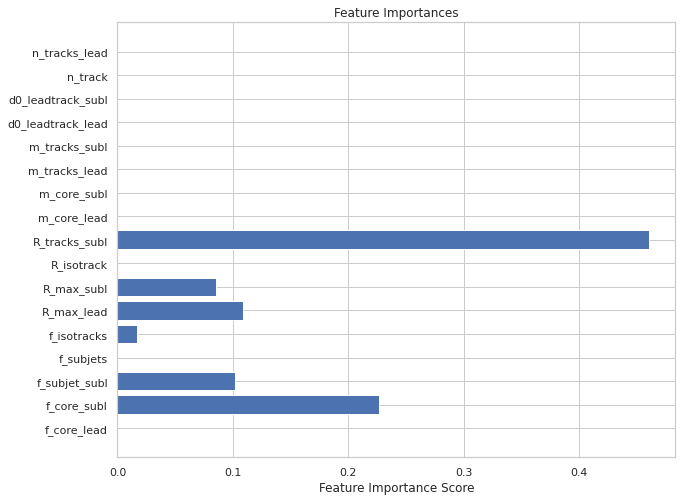

/tmp/ipykernel_389/3592393373.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['eventID_mod'] = df['event_id'] % 5
/tmp/ipykernel_389/3592393373.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['weight'] = df['event_weight'] * df['pT_weight']


train bkg: 489859, train signal: 16439, test bkg: 122617, test signal: 4203
Fitting 3 folds for each of 30 candidates, totalling 90 fits


/tmp/ipykernel_389/3592393373.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data.rename(columns=feature_mapping, inplace=True)
/tmp/ipykernel_389/3592393373.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_data.rename(columns=feature_mapping, inplace=True)
/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86

[0]	validation_0-logloss:0.34094
[1]	validation_0-logloss:0.33737
[2]	validation_0-logloss:0.33386
[3]	validation_0-logloss:0.33050
[4]	validation_0-logloss:0.32719
[5]	validation_0-logloss:0.32400
[6]	validation_0-logloss:0.32092
[7]	validation_0-logloss:0.31794
[8]	validation_0-logloss:0.31499
[9]	validation_0-logloss:0.31213
[10]	validation_0-logloss:0.30934
[11]	validation_0-logloss:0.30666
[12]	validation_0-logloss:0.30613
[13]	validation_0-logloss:0.30562
[14]	validation_0-logloss:0.30513
[15]	validation_0-logloss:0.30466
[16]	validation_0-logloss:0.30420
[17]	validation_0-logloss:0.30376
[18]	validation_0-logloss:0.30333
[19]	validation_0-logloss:0.30292
[20]	validation_0-logloss:0.30253
[21]	validation_0-logloss:0.30214
[22]	validation_0-logloss:0.30177
[23]	validation_0-logloss:0.30141
[24]	validation_0-logloss:0.30107
[25]	validation_0-logloss:0.30073
[26]	validation_0-logloss:0.30041
[27]	validation_0-logloss:0.30010
[28]	validation_0-logloss:0.29980
[29]	validation_0-loglos

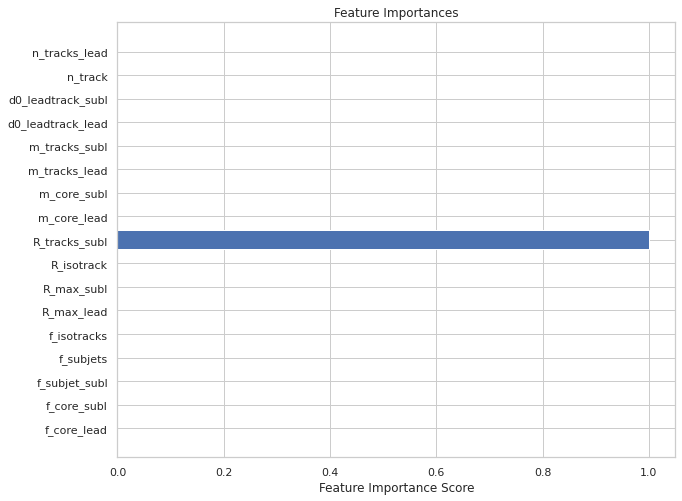

/tmp/ipykernel_389/3592393373.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['eventID_mod'] = df['event_id'] % 5
/tmp/ipykernel_389/3592393373.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['weight'] = df['event_weight'] * df['pT_weight']


train bkg: 960356, train signal: 91631, test bkg: 240022, test signal: 22940
Fitting 3 folds for each of 30 candidates, totalling 90 fits


/tmp/ipykernel_389/3592393373.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data.rename(columns=feature_mapping, inplace=True)
/tmp/ipykernel_389/3592393373.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_data.rename(columns=feature_mapping, inplace=True)
/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86

[0]	validation_0-logloss:0.51691
[1]	validation_0-logloss:0.47957
[2]	validation_0-logloss:0.43974
[3]	validation_0-logloss:0.41005
[4]	validation_0-logloss:0.38684
[5]	validation_0-logloss:0.35860
[6]	validation_0-logloss:0.33463
[7]	validation_0-logloss:0.31538
[8]	validation_0-logloss:0.30042
[9]	validation_0-logloss:0.28601
[10]	validation_0-logloss:0.27079
[11]	validation_0-logloss:0.26004
[12]	validation_0-logloss:0.25130
[13]	validation_0-logloss:0.24060
[14]	validation_0-logloss:0.23119
[15]	validation_0-logloss:0.22613
[16]	validation_0-logloss:0.22112
[17]	validation_0-logloss:0.21433
[18]	validation_0-logloss:0.20825
[19]	validation_0-logloss:0.20226
[20]	validation_0-logloss:0.19573
[21]	validation_0-logloss:0.19132
[22]	validation_0-logloss:0.18568
[23]	validation_0-logloss:0.18371
[24]	validation_0-logloss:0.18014
[25]	validation_0-logloss:0.18040
[26]	validation_0-logloss:0.17798
[27]	validation_0-logloss:0.17485
[28]	validation_0-logloss:0.17286
[29]	validation_0-loglos

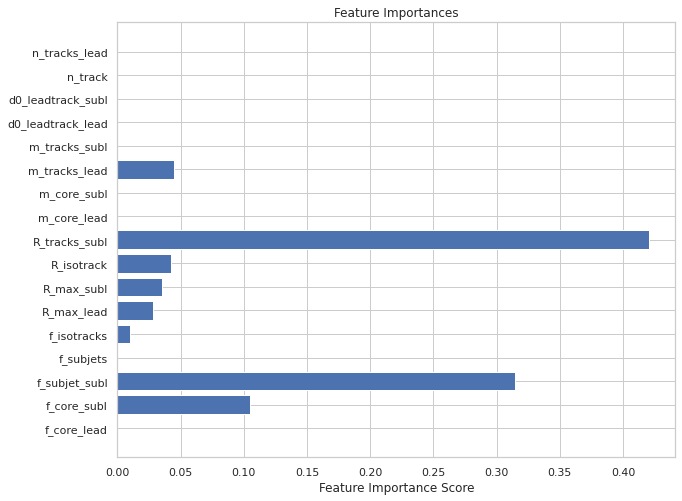

train bkg: 1743956, train signal: 234487, test bkg: 436601, test signal: 58669


/tmp/ipykernel_389/3592393373.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data.rename(columns=feature_mapping, inplace=True)
/tmp/ipykernel_389/3592393373.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_data.rename(columns=feature_mapping, inplace=True)


Fitting 3 folds for each of 30 candidates, totalling 90 fits


/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.68221
[1]	validation_0-logloss:0.65180
[2]	validation_0-logloss:0.62410
[3]	validation_0-logloss:0.59885
[4]	validation_0-logloss:0.57477
[5]	validation_0-logloss:0.55266
[6]	validation_0-logloss:0.53197
[7]	validation_0-logloss:0.51272
[8]	validation_0-logloss:0.49457
[9]	validation_0-logloss:0.47757
[10]	validation_0-logloss:0.46144
[11]	validation_0-logloss:0.44656
[12]	validation_0-logloss:0.43249
[13]	validation_0-logloss:0.42027
[14]	validation_0-logloss:0.40772
[15]	validation_0-logloss:0.39640
[16]	validation_0-logloss:0.38612
[17]	validation_0-logloss:0.37531
[18]	validation_0-logloss:0.36660
[19]	validation_0-logloss:0.35741
[20]	validation_0-logloss:0.34796
[21]	validation_0-logloss:0.34032
[22]	validation_0-logloss:0.33245
[23]	validation_0-logloss:0.32552
[24]	validation_0-logloss:0.31836
[25]	validation_0-logloss:0.31079
[26]	validation_0-logloss:0.30489
[27]	validation_0-logloss:0.29869
[28]	validation_0-logloss:0.29210
[29]	validation_0-loglos

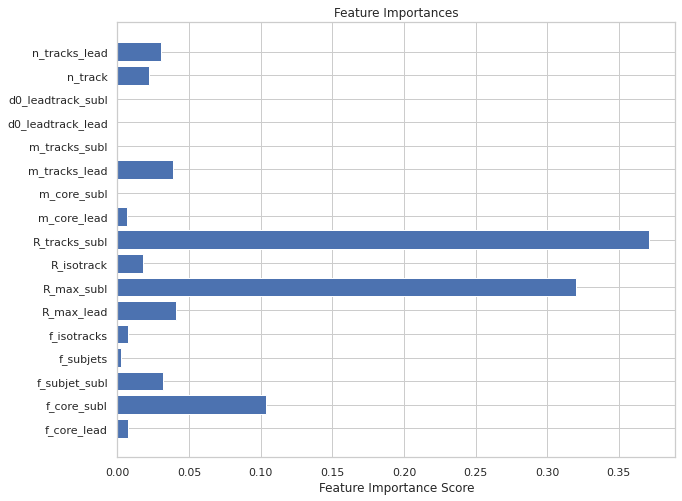

In [38]:
fpr1, tpr1, thresholds1, auc1 = BDT(df_1p1p)
fpr2, tpr2, thresholds2, auc2 = BDT(df_3p3p)
fpr3, tpr3, thresholds3, auc3 = BDT(df_1p3p)
fpr4, tpr4, thresholds4, auc4 = BDT(df)

/tmp/ipykernel_389/1803732940.py:15: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr1, 1/fpr1, lw=1, label='1p1p (area = %0.5f)' % auc1)
/tmp/ipykernel_389/1803732940.py:16: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2, 1/fpr2, lw=1, label='3p3p (area = %0.5f)' % auc2)
/tmp/ipykernel_389/1803732940.py:17: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr3, 1/fpr3, lw=1, label='1p3p (area = %0.5f)' % auc3)


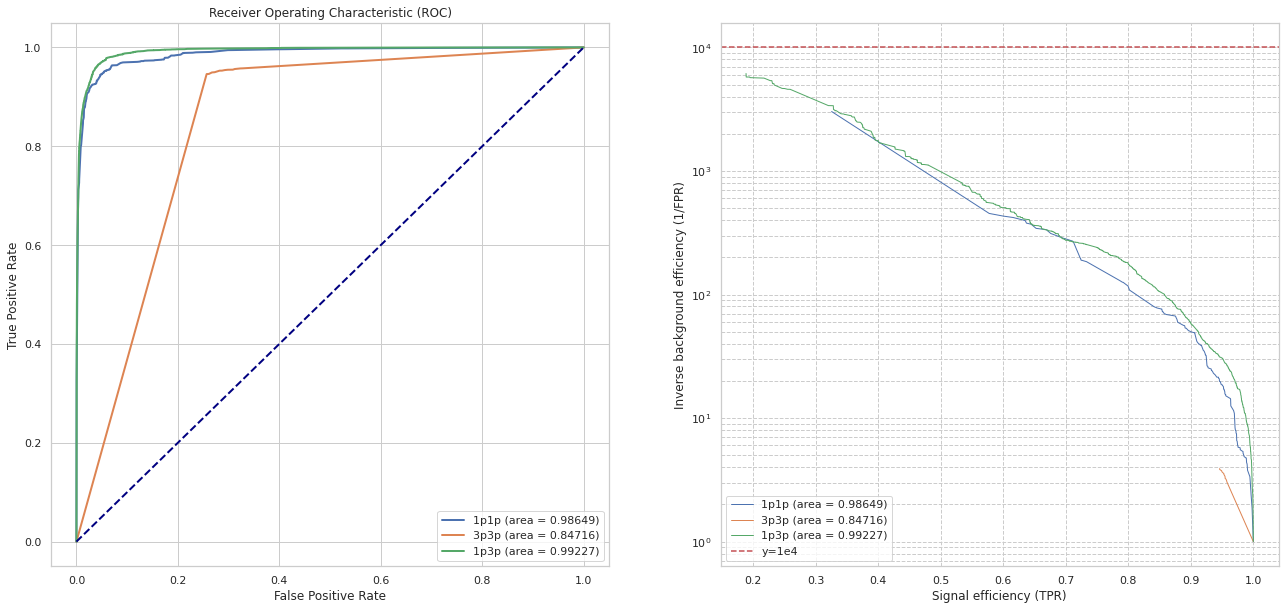

In [40]:
# Plotting ROC Curve
plt.figure(figsize=(22, 10))
plt.subplot(121)
plt.plot(fpr1, tpr1, lw=2, label='1p1p (area = %0.5f)' % auc1)
plt.plot(fpr2, tpr2, lw=2, label='3p3p (area = %0.5f)' % auc2)
plt.plot(fpr3, tpr3, lw=2, label='1p3p (area = %0.5f)' % auc3)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)

plt.subplot(122)
plt.plot(tpr1, 1/fpr1, lw=1, label='1p1p (area = %0.5f)' % auc1)
plt.plot(tpr2, 1/fpr2, lw=1, label='3p3p (area = %0.5f)' % auc2)
plt.plot(tpr3, 1/fpr3, lw=1, label='1p3p (area = %0.5f)' % auc3)

plt.xlabel('Signal efficiency (TPR)')
plt.ylabel('Inverse background efficiency (1/FPR)')
plt.yscale('log')
# yticks = np.linspace(0, 10e9, 71)
# plt.yticks(yticks, labels=[str(ytick) for ytick in yticks])
plt.axhline(y=1e4, color='r', linestyle='--', label='y=1e4')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()


train bkg: 1743956, train signal: 234487, test bkg: 436601, test signal: 58669


/tmp/ipykernel_389/4124954595.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data.rename(columns=feature_mapping, inplace=True)
/tmp/ipykernel_389/4124954595.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_data.rename(columns=feature_mapping, inplace=True)


Fitting 3 folds for each of 30 candidates, totalling 90 fits


/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.68221
[1]	validation_0-logloss:0.65180
[2]	validation_0-logloss:0.62410
[3]	validation_0-logloss:0.59885
[4]	validation_0-logloss:0.57477
[5]	validation_0-logloss:0.55266
[6]	validation_0-logloss:0.53197
[7]	validation_0-logloss:0.51272
[8]	validation_0-logloss:0.49457
[9]	validation_0-logloss:0.47757
[10]	validation_0-logloss:0.46144
[11]	validation_0-logloss:0.44656
[12]	validation_0-logloss:0.43249
[13]	validation_0-logloss:0.42027
[14]	validation_0-logloss:0.40772
[15]	validation_0-logloss:0.39640
[16]	validation_0-logloss:0.38612
[17]	validation_0-logloss:0.37531
[18]	validation_0-logloss:0.36660
[19]	validation_0-logloss:0.35741
[20]	validation_0-logloss:0.34796
[21]	validation_0-logloss:0.34032
[22]	validation_0-logloss:0.33245
[23]	validation_0-logloss:0.32552
[24]	validation_0-logloss:0.31836
[25]	validation_0-logloss:0.31079
[26]	validation_0-logloss:0.30489
[27]	validation_0-logloss:0.29869
[28]	validation_0-logloss:0.29210
[29]	validation_0-loglos

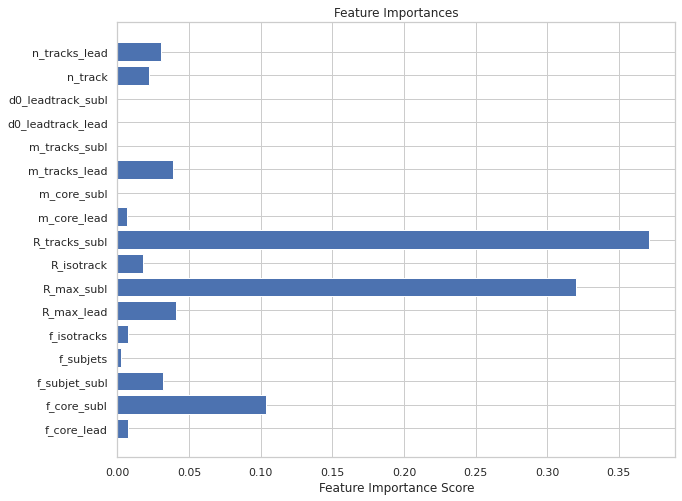

In [41]:
training_vars = ["f_core_lead",
                "f_core_subl",
                "f_subjet_subl",
                "f_subjets",
                "f_isotracks",
                "R_max_lead",
                "R_max_subl",
                "R_isotrack",
                "R_tracks_subl",
                "m_core_lead",
                "m_core_subl",
                "m_tracks_lead",
                "m_tracks_subl",
                "d0_leadtrack_lead",
                "d0_leadtrack_subl",
                "n_track",
                "n_tracks_lead"]


# Scrambling
# Calculate the modulo of each eventID with 5
df['eventID_mod'] = df['event_id'] % 5

df['weight'] = df['event_weight'] * df['pT_weight']

log_vars = ["f_isotracks", "m_core_lead", "m_core_subl", "m_tracks_lead", "m_tracks_subl"]
abs_log_var = ["d0_leadtrack_lead", "d0_leadtrack_subl"]

train_df = df[df['eventID_mod'] < 4] # 80%
test_df = df[df['eventID_mod'] == 4] # 20%
print(f'train bkg: {len(train_df[train_df.label==0])}, train signal: {len(train_df[train_df.label==1])}, test bkg: {len(test_df[test_df.label==0])}, test signal: {len(test_df[test_df.label==1])}')

train_df = train_df.drop(columns='eventID_mod')
test_df = test_df.drop(columns='eventID_mod')

# Training & Testing sets
training_data, testing_data, training_labels, testing_labels, training_weights, testing_weights = \
train_df[training_vars], test_df[training_vars], train_df['label'], test_df['label'], train_df['weight'], test_df['weight']

#Change column names to integers if needed (for ML models that expect numerical feature names)
feature_mapping = {feature: i for i, feature in enumerate(training_data.columns)}
training_data.rename(columns=feature_mapping, inplace=True)
feature_mapping = {feature: i for i, feature in enumerate(testing_data.columns)}
testing_data.rename(columns=feature_mapping, inplace=True)

# Define the classifier
bdt = XGBClassifier(random_state=0, verbosity=1)

# Define the parameter distribution
param_dist = {
    'n_estimators': [100, 150, 200, 250, 300, 350, 400, 450, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.3],
    'max_depth': [2, 3, 4, 5, 6]
}

# Define the search with RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=bdt, param_distributions=param_dist, n_iter=30, scoring='accuracy', cv=3, verbose=2, random_state=0, n_jobs=-1)

# Perform the search
# Note: We don't use the testing set here; it's for final evaluation
random_search.fit(training_data, training_labels, sample_weight=training_weights)

# Best estimator found by RandomizedSearchCV
best_estimator = random_search.best_estimator_

# Manually apply early stopping using a portion of the training set as a validation set
# Note: XGBoost handles validation sets for early stopping, but we use training and testing sets as provided
eval_set = [(testing_data, testing_labels)]
best_estimator.fit(training_data, training_labels, sample_weight=training_weights, early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set, verbose=True)

# Predictions and final evaluation on the testing set
predictions = best_estimator.predict(testing_data)
accuracy = accuracy_score(testing_labels, predictions, sample_weight=testing_weights)

# Output the results
print("Best parameters found: ", random_search.best_params_)
print("Testing accuracy after early stopping: ", accuracy)

# Predict probabilities for the testing data
probs = best_estimator.predict_proba(testing_data)
probs = probs[:, 1]

# Feature Importance
importance = best_estimator.feature_importances_
# Re-map the feature importance scores to the original feature names
feature_importances = {training_vars[i]: score for i, score in enumerate(importance)}

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(range(len(feature_importances)), list(feature_importances.values()), align='center')
plt.yticks(range(len(feature_importances)), list(feature_importances.keys()))
plt.xlabel('Feature Importance Score')
plt.title('Feature Importances')
plt.show()

/tmp/ipykernel_389/2916452910.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_subset.rename(columns=feature_mapping, inplace=True)
/tmp/ipykernel_389/2916452910.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_subset.rename(columns=feature_mapping, inplace=True)
/tmp/ipykernel_389/2916452910.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_subset.rename(columns=feature_mapping, inplace=True)
/tmp/ipykernel_389/291645

<Figure size 720x576 with 0 Axes>

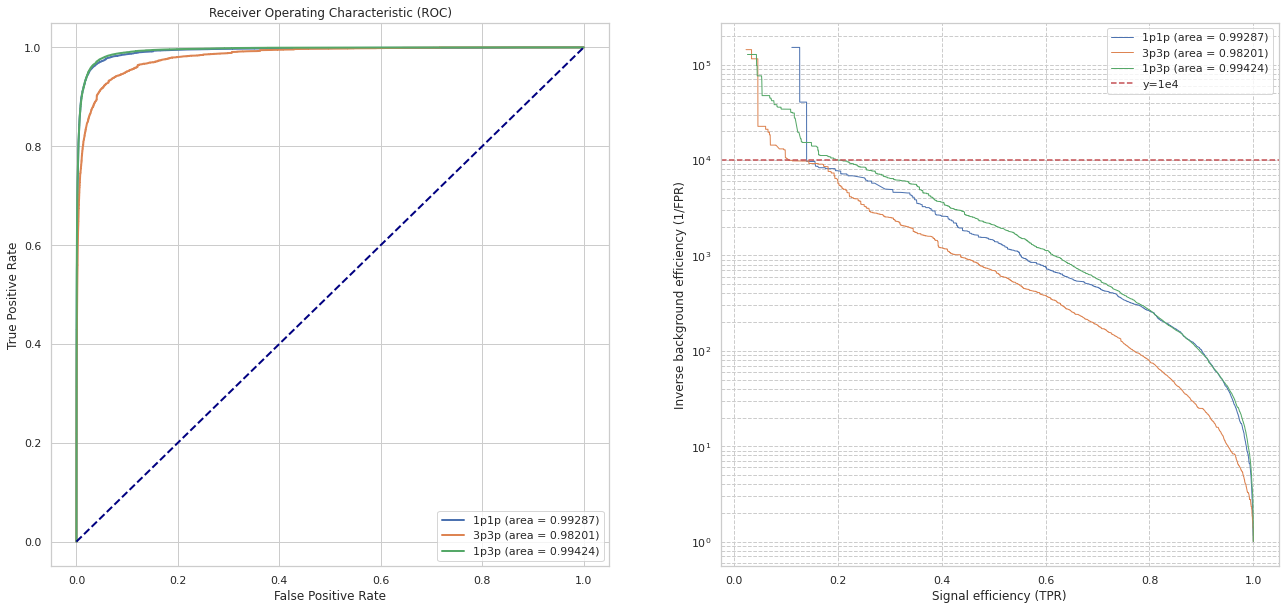

In [47]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

def evaluate_model_and_plot_roc(bdt, df_subset, training_vars, subset_label):
    # Prepare the subset's data
    X_subset = df_subset[training_vars]
    y_subset = df_subset['label']
    weights_subset = df_subset['weight']
    
        #Change column names to integers if needed (for ML models that expect numerical feature names)
    feature_mapping = {feature: i for i, feature in enumerate(X_subset.columns)}
    X_subset.rename(columns=feature_mapping, inplace=True)
    
    # Predict probabilities for the subset data
    probs_subset = bdt.predict_proba(X_subset)[:, 1]  # Assuming positive class is at index 1

    # Calculate FPR, TPR, and AUC for the subset
    fpr, tpr, thresholds = roc_curve(y_subset, probs_subset, sample_weight=weights_subset)
    auc_score = roc_auc_score(y_subset, probs_subset, sample_weight=weights_subset)
    return fpr, tpr, auc_score

# After training and optimizing your BDT, you can evaluate and plot ROC curves for the subsets
plt.figure(figsize=(10, 8))


fpr5, tpr5, auc5 = evaluate_model_and_plot_roc(best_estimator, df_1p1p, training_vars, '1p1p')
fpr6, tpr6, auc6 = evaluate_model_and_plot_roc(best_estimator, df_3p3p, training_vars, '3p3p')
fpr7, tpr7, auc7 = evaluate_model_and_plot_roc(best_estimator, df_1p3p, training_vars, '1p3p')

# Plotting ROC Curve
plt.figure(figsize=(22, 10))
plt.subplot(121)
plt.plot(fpr5, tpr5, lw=2, label='1p1p (area = %0.5f)' % auc5)
plt.plot(fpr6, tpr6, lw=2, label='3p3p (area = %0.5f)' % auc6)
plt.plot(fpr7, tpr7, lw=2, label='1p3p (area = %0.5f)' % auc7)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)

plt.subplot(122)
plt.plot(tpr5, 1/fpr5, lw=1, label='1p1p (area = %0.5f)' % auc5)
plt.plot(tpr6, 1/fpr6, lw=1, label='3p3p (area = %0.5f)' % auc6)
plt.plot(tpr7, 1/fpr7, lw=1, label='1p3p (area = %0.5f)' % auc7)

plt.xlabel('Signal efficiency (TPR)')
plt.ylabel('Inverse background efficiency (1/FPR)')
plt.yscale('log')
# yticks = np.linspace(0, 10e9, 71)
# plt.yticks(yticks, labels=[str(ytick) for ytick in yticks])
plt.axhline(y=1e4, color='r', linestyle='--', label='y=1e4')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()


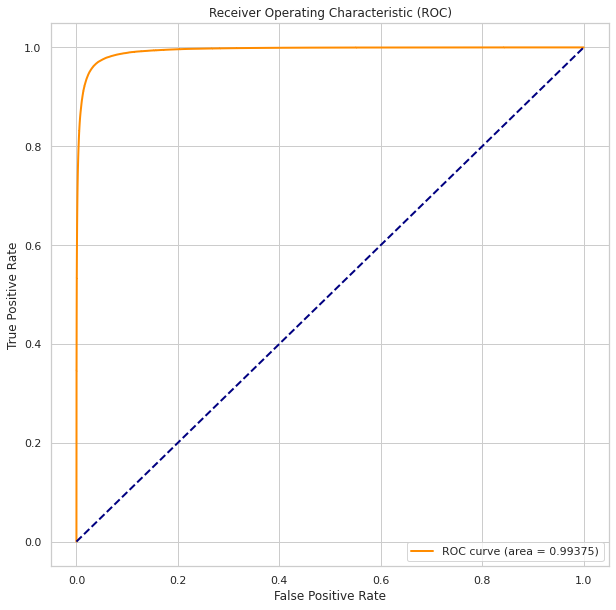

In [12]:
# Old BDT ROC

scores = df['bdt_score']
true_labels = df['label'] 


fpr, tpr, thresholds = roc_curve(true_labels, scores)

# Calculate the Area Under the Curve (AUC) for ROC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.5f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [19]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Assuming train_df, test_df, and training_vars are already defined in your workspace

# Training & Testing sets as provided
training_data, testing_data, training_labels, testing_labels, training_weights, testing_weights = \
    train_df[training_vars], test_df[training_vars], train_df['label'], test_df['label'], train_df['weight'], test_df['weight']

# Define the classifier
bdt = XGBClassifier(random_state=0, verbosity=1)

# Define the parameter distribution
param_dist = {
    'n_estimators': [100, 150, 200, 250, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [2, 3, 4, 5, 6]
}

# Define the search with RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=bdt, param_distributions=param_dist, n_iter=10, scoring='accuracy', cv=3, verbose=2, random_state=0, n_jobs=-1)

# Perform the search
# Note: We don't use the testing set here; it's for final evaluation
random_search.fit(training_data, training_labels, sample_weight=training_weights)

# Best estimator found by RandomizedSearchCV
best_estimator = random_search.best_estimator_

# Manually apply early stopping using a portion of the training set as a validation set
# Note: XGBoost handles validation sets for early stopping, but we use training and testing sets as provided
eval_set = [(testing_data, testing_labels)]
best_estimator.fit(training_data, training_labels, sample_weight=training_weights, early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set, verbose=True)

# Predictions and final evaluation on the testing set
predictions = best_estimator.predict(testing_data)
accuracy = accuracy_score(testing_labels, predictions, sample_weight=testing_weights)

# Output the results
print("Best parameters found: ", random_search.best_params_)
print("Testing accuracy after early stopping: ", accuracy)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/cvmfs/sft.cern.ch/lcg/views/LCG_104a_cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/cvmfs/sft.cern.ch/lcg/views/LCG_104a_cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.62437
[1]	validation_0-logloss:0.56794
[2]	validation_0-logloss:0.52116
[3]	validation_0-logloss:0.48210
[4]	validation_0-logloss:0.44932
[5]	validation_0-logloss:0.42171
[6]	validation_0-logloss:0.39842
[7]	validation_0-logloss:0.37878
[8]	validation_0-logloss:0.36223
[9]	validation_0-logloss:0.34832
[10]	validation_0-logloss:0.33669
[11]	validation_0-logloss:0.32701
[12]	validation_0-logloss:0.31904
[13]	validation_0-logloss:0.31253
[14]	validation_0-logloss:0.30730
[15]	validation_0-logloss:0.30319
[16]	validation_0-logloss:0.30005
[17]	validation_0-logloss:0.29776
[18]	validation_0-logloss:0.29621
[19]	validation_0-logloss:0.29530
[20]	validation_0-logloss:0.29495
[21]	validation_0-logloss:0.29508
[22]	validation_0-logloss:0.29564
[23]	validation_0-logloss:0.29656
[24]	validation_0-logloss:0.29780
[25]	validation_0-logloss:0.29930
[26]	validation_0-logloss:0.30103
[27]	validation_0-logloss:0.30296
[28]	validation_0-logloss:0.30506
[29]	validation_0-loglos

In [13]:
from xgboost import XGBClassifier

# create the BDT

params = {
'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 200,
'eval_metric': 'logloss',
'random_state': 0,
'gamma': 0.001,
'verbosity': 2
}
bdt = XGBClassifier(**params)
print(type(bdt))

# Train the classifier
bdt.fit(training_data, training_labels, eval_set=[(testing_data, testing_labels)], sample_weight=training_weights, early_stopping_rounds=10, verbose=True)

<class 'xgboost.sklearn.XGBClassifier'>


/cvmfs/sft.cern.ch/lcg/views/LCG_104a_cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[21:08:21] INFO: /build/jenkins/workspace/lcg_release_pipeline/build/pyexternals/xgboost-1.7.3/src/xgboost/1.7.3/src/tree/updater_prune.cc:98: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[0]	validation_0-logloss:0.62437
[21:08:21] INFO: /build/jenkins/workspace/lcg_release_pipeline/build/pyexternals/xgboost-1.7.3/src/xgboost/1.7.3/src/tree/updater_prune.cc:98: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[1]	validation_0-logloss:0.56794
[21:08:21] INFO: /build/jenkins/workspace/lcg_release_pipeline/build/pyexternals/xgboost-1.7.3/src/xgboost/1.7.3/src/tree/updater_prune.cc:98: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[2]	validation_0-logloss:0.52116
[21:08:21] INFO: /build/jenkins/workspace/lcg_release_pipeline/build/pyexternals/xgboost-1.7.3/src/xgboost/1.7.3/src/tree/updater_prune.cc:98: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[3]	validation_0-logloss:0.48210
[21:08:21] INFO: /build/jenkins/workspace/lcg_releas

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.001, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=0, ...)

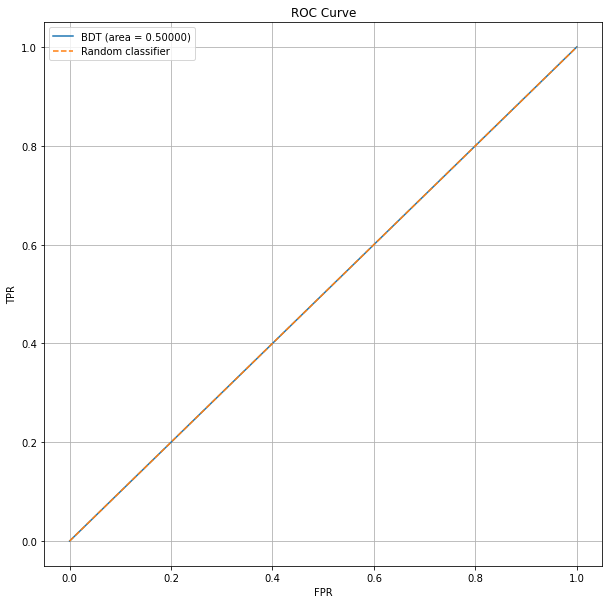

In [14]:
# Predict probabilities for the testing data
probs = bdt.predict_proba(testing_data)
probs = probs[:, 1]

fpr_w, tpr_w, thresholds_w = roc_curve(testing_labels, probs, sample_weight=testing_weights)
auc_w = roc_auc_score(testing_labels, probs, sample_weight=testing_weights)
plt.figure(figsize=(10, 10))
plt.plot(fpr_w, tpr_w, label='BDT (area = {:.5f})'.format(auc_w))
plt.plot([0, 1], [0, 1], linestyle='--', label='Random classifier')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
# shuffle the data
combined_data = df.sample(frac=1, random_state=42).reset_index(drop=True)

pd_data = combined_data[training_vars]
pd_weights = combined_data["weight"]
pd_labels = combined_data["label"]
print(pd_data)

feature_mapping = {feature: i for i, feature in enumerate(pd_data.columns)}
pd_data.rename(columns=feature_mapping, inplace=True)

print(pd_data)

# split the data into training and testing sets
training_data = pd_data[:int(len(pd_data)*0.8)]
training_labels = pd_labels[:int(len(pd_labels)*0.8)]
training_weights = pd_weights[:int(len(pd_weights)*0.8)]
print("training data: ", training_data.shape)
print("training labels: ", training_labels.shape)
print("training weights: ", training_weights.shape)

testing_data = pd_data[int(len(pd_data)*0.8):]
testing_labels = pd_labels[int(len(pd_labels)*0.8):]
testing_weights = pd_weights[int(len(pd_weights)*0.8):]
print("testing data: ", testing_data.shape)
print("testing labels: ", testing_labels.shape)
print("testing weights: ", testing_weights.shape)

from xgboost import XGBClassifier

# create the BDT

params = {
'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150,
'eval_metric': 'logloss',
'random_state': 0,
'gamma': 0.001,
'verbosity': 2
}
bdt = XGBClassifier(**params)
print(type(bdt))

# Train the classifier
# bdt.fit(training_data, training_labels, sample_weight=training_weights)
bdt.fit(training_data, training_labels, eval_set=[(testing_data, testing_labels)], sample_weight=training_weights)

        f_core_lead  f_core_subl  f_subjet_subl  f_subjets  f_isotracks  \
0          0.827793     0.350880       0.062836   0.858453    -2.799728   
1          0.764538     0.637128       0.063641   0.695171    -4.067375   
2          0.732874     0.404267       0.067793   0.794315    -3.245469   
3          0.904525     0.795641       0.039079   0.908339    -5.659952   
4          0.912951     0.423179       0.030607   0.743083    -4.251077   
...             ...          ...            ...        ...          ...   
504635     0.876822     0.478093       0.067242   0.868660    -3.982208   
504636     0.879936     0.320422       0.042640   0.774761    -4.539171   
504637     0.850109     0.076170       0.039220   0.760628    -4.561179   
504638     0.941038     0.653944       0.222461   0.715479    -3.761817   
504639     0.767183     0.369936       0.034320   0.814702    -4.180725   

        R_max_lead  R_max_subl  R_isotrack  R_tracks_subl  m_core_lead  \
0         0.029167    0.0

/tmp/ipykernel_7500/279282278.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_data.rename(columns=feature_mapping, inplace=True)


[02:40:24] INFO: /build/jenkins/workspace/lcg_release_pipeline/build/pyexternals/xgboost-1.7.3/src/xgboost/1.7.3/src/tree/updater_prune.cc:98: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[0]	validation_0-logloss:0.64137
[02:40:24] INFO: /build/jenkins/workspace/lcg_release_pipeline/build/pyexternals/xgboost-1.7.3/src/xgboost/1.7.3/src/tree/updater_prune.cc:98: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[1]	validation_0-logloss:0.59834
[02:40:25] INFO: /build/jenkins/workspace/lcg_release_pipeline/build/pyexternals/xgboost-1.7.3/src/xgboost/1.7.3/src/tree/updater_prune.cc:98: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[2]	validation_0-logloss:0.56243
[02:40:25] INFO: /build/jenkins/workspace/lcg_release_pipeline/build/pyexternals/xgboost-1.7.3/src/xgboost/1.7.3/src/tree/updater_prune.cc:98: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[3]	validation_0-logloss:0.53237
[02:40:25] INFO: /build/jenkins/workspace/lcg_releas

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.001, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=0, ...)

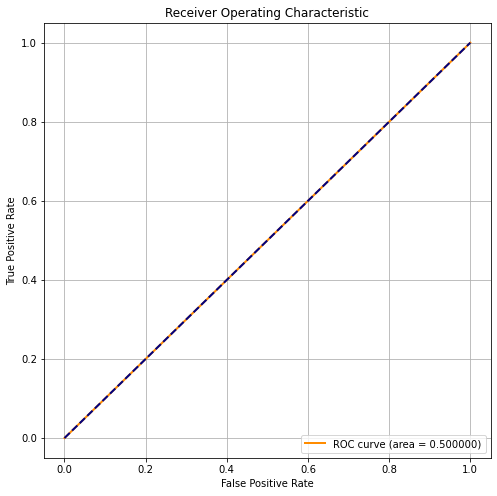

In [19]:
# Plotting the ROC
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predict probabilities
probabilities = bdt.predict_proba(testing_data)[:,1]

# Calculate TPR and FPR
fpr, tpr, _ = roc_curve(testing_labels, probabilities, sample_weight=testing_weights)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.6f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
